# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name:**  Ferdinand Kulman  
**Neptun ID:** YR9905  

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
import os
import numpy as np
import string
import pickle
import requests
import pandas as pd
import nltk

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import transforms

import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from tqdm import tqdm

from transformers import BlipProcessor, BlipForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


c:\Users\ferdi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k -p datasets/flickr8k --unzip

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

In [2]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<UNK>", 1: "<SOS>", 2: "<EOS>"}
        self.stoi = {"<UNK>": 0, "<SOS>": 1, "<EOS>": 2}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        text = text.lower().translate(str.maketrans('', '', string.punctuation))
        return text.split()

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 3

        for sentence in sentence_list:
            frequencies.update(self.tokenize(sentence))

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.transform = transform
        self.df = pd.read_csv(os.path.join(root_dir, captions_file))
        self.imgs = self.df["image"].values
        self.captions = self.df["caption"].values
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, "Images", self.imgs[idx])
        caption = self.captions[idx]

        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file not found: {img_path}")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(caption_vec)


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ferdi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Example output from dataset class

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = FlickrDataset(
    root_dir="./datasets/flickr8k",
    captions_file="captions.txt",
    transform=transform
)

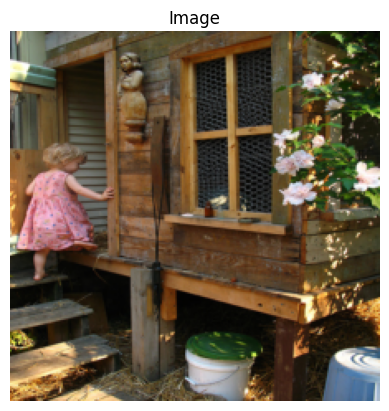

Tokenized Caption (Numericalized): tensor([ 1,  3,  4,  5,  3,  6,  7,  8,  9, 10,  3, 11, 12, 13,  5, 14,  0, 15,
         2])
Decoded Caption (Text): <SOS> a child in a pink dress is climbing up a set of stairs in an <UNK> way <EOS>


In [6]:
def show_image(tensor_image, title="Image"):
    image = tensor_image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

img, caps = dataset[0]

show_image(img)

print("Tokenized Caption (Numericalized):", caps)

decoded_caption = [dataset.vocab.itos[token] for token in caps.tolist()]
print("Decoded Caption (Text):", " ".join(decoded_caption))


Split your dataset into train, val and test sets

In [4]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

print(f"Train size: {len(train_set)}")
print(f"Validation size: {len(val_set)}")
print(f"Test size: {len(test_set)}")

Train size: 32364
Validation size: 4045
Test size: 4046


Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

Images batch shape: torch.Size([32, 3, 224, 224])
Captions batch shape: torch.Size([32, 19])
Images batch shape: torch.Size([4, 3, 224, 224])
Captions batch shape: torch.Size([4, 20])


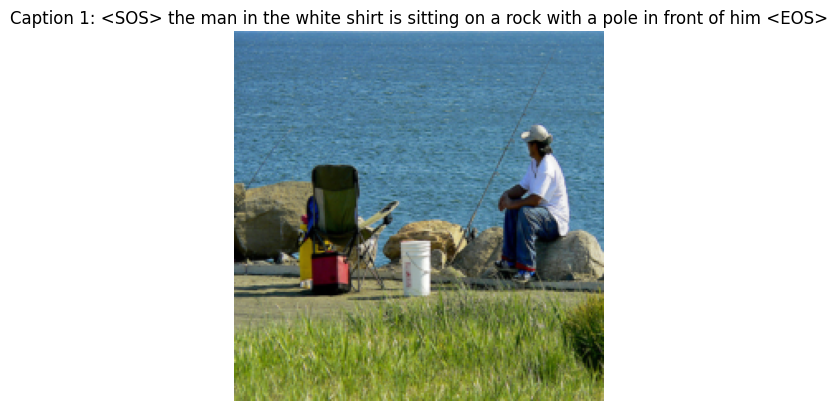

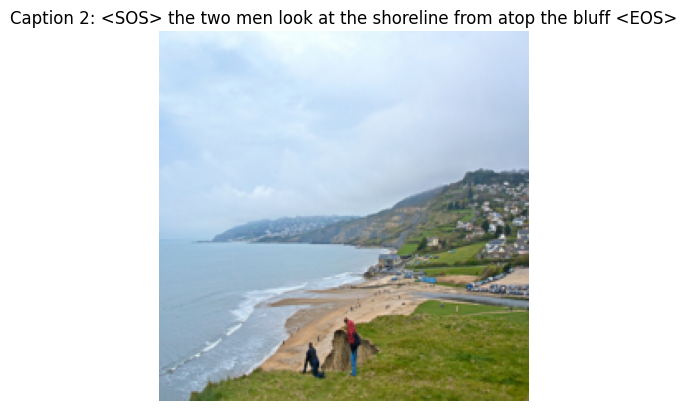

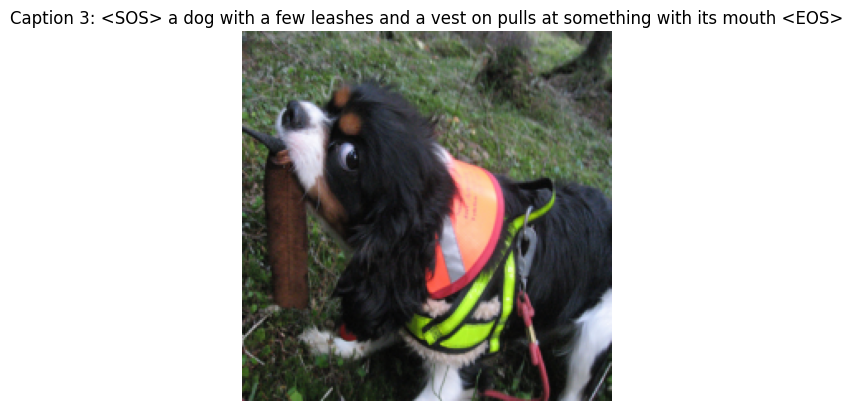

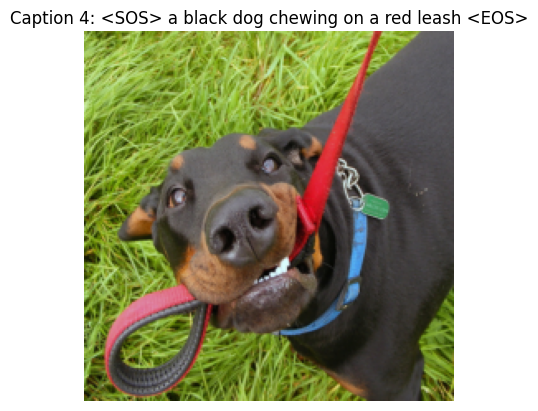

In [7]:
def collate_fn(batch):
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)

    images = torch.stack(images)
    captions = pad_sequence(captions, batch_first=True, padding_value=dataset.vocab.stoi["<UNK>"])
    return images, captions

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for imgs, caps in train_loader:
    print("Images batch shape:", imgs.shape)
    print("Captions batch shape:", caps.shape)
    break

sample_batch_size = 4
sample_loader = DataLoader(train_set, batch_size=sample_batch_size, shuffle=True, collate_fn=collate_fn)

for images, captions in sample_loader:
    break

print("Images batch shape:", images.shape)
print("Captions batch shape:", captions.shape)

readable_captions = [
    [dataset.vocab.itos[token] for token in caption if token != dataset.vocab.stoi["<UNK>"]]
    for caption in captions.tolist()
]

for i in range(sample_batch_size):
    img = images[i]
    caption = f"Caption {i+1}: {' '.join(readable_captions[i])}"
    show_image(img, title=caption)


#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [9]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()

        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False

        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.embed = nn.Conv2d(2048, embed_size, kernel_size=1)

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = self.embed(features)
        return features.permute(0, 2, 3, 1)

In [10]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, hidden_state):
        batch_size, H, W, embed_size = features.size()
        features = features.view(batch_size, -1, embed_size)
        att1 = self.encoder_att(features)
        att2 = self.decoder_att(hidden_state).unsqueeze(1)
        att = self.full_att(self.relu(att1 + att2))
        att = att.squeeze(2)
        alpha = self.softmax(att)
        context = (features * alpha.unsqueeze(2)).sum(dim=1)
        alpha = alpha.view(batch_size, H, W)
        return context, alpha


In [11]:
class Decoder(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim):
        super(Decoder, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_size = embed_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.attention = Attention(embed_size, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + embed_size, decoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_h = nn.Linear(embed_size, decoder_dim)
        self.init_c = nn.Linear(embed_size, decoder_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        batch_size = features.size(0)
        caption_lengths = captions.size(1)
        avg_features = features.mean(dim=(1, 2))
        h = self.init_h(avg_features)
        c = self.init_c(avg_features)
        embeddings = self.embedding(captions[:, :-1])
        predictions = torch.zeros(batch_size, caption_lengths - 1, self.vocab_size).to(features.device)
        alphas = torch.zeros(batch_size, caption_lengths - 1, features.size(1), features.size(2)).to(features.device)
        for t in range(caption_lengths - 1):
            context, alpha = self.attention(features, h)
            lstm_input = torch.cat([embeddings[:, t, :], context], dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            output = self.fc(self.dropout(h))
            predictions[:, t, :] = output
            alphas[:, t, :, :] = alpha

        return predictions, alphas


Combine the encoder - attention - decoder

In [12]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim=2048, decoder_dim=512):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs, alphas = self.decoder(features, captions)
        return outputs, alphas

### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

Training Epoch 1/10: 100%|##########| 1012/1012 [08:30<00:00,  1.98it/s]


Epoch [1/10], Training Loss: 4.6461
Validation Loss: 4.0675


Training Epoch 2/10: 100%|##########| 1012/1012 [06:49<00:00,  2.47it/s]


Epoch [2/10], Training Loss: 3.8977
Validation Loss: 3.6752


Training Epoch 3/10: 100%|##########| 1012/1012 [06:48<00:00,  2.48it/s]


Epoch [3/10], Training Loss: 3.5983
Validation Loss: 3.4426


Training Epoch 4/10: 100%|##########| 1012/1012 [06:55<00:00,  2.44it/s]


Epoch [4/10], Training Loss: 3.4001
Validation Loss: 3.2814


Training Epoch 5/10: 100%|##########| 1012/1012 [06:45<00:00,  2.50it/s]


Epoch [5/10], Training Loss: 3.2555
Validation Loss: 3.1652


Training Epoch 6/10: 100%|##########| 1012/1012 [06:46<00:00,  2.49it/s]


Epoch [6/10], Training Loss: 3.1411
Validation Loss: 3.0737


Training Epoch 7/10: 100%|##########| 1012/1012 [06:46<00:00,  2.49it/s]


Epoch [7/10], Training Loss: 3.0464
Validation Loss: 3.0040


Training Epoch 8/10: 100%|##########| 1012/1012 [06:53<00:00,  2.44it/s]


Epoch [8/10], Training Loss: 2.9695
Validation Loss: 2.9431


Training Epoch 9/10: 100%|##########| 1012/1012 [06:55<00:00,  2.43it/s]


Epoch [9/10], Training Loss: 2.8993
Validation Loss: 2.8933


Training Epoch 10/10: 100%|##########| 1012/1012 [06:55<00:00,  2.44it/s]


Epoch [10/10], Training Loss: 2.8380
Validation Loss: 2.8523


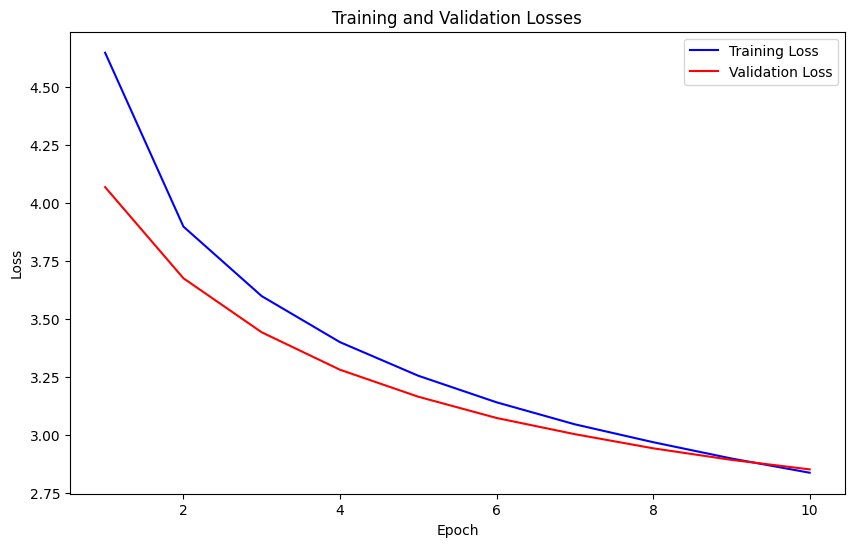

In [ ]:
batch_size = 32
embed_size = 256
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 1e-4
num_epochs = 10
vocab_size = len(dataset.vocab)

model = ImageCaptioningModel(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<UNK>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, captions in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}", ascii=True):
        images, captions = images.to(device), captions.to(device)

        outputs, _ = model(images, captions)
        targets = captions[:, 1:]

        target_lengths = (targets != dataset.vocab.stoi["<UNK>"]).sum(dim=1).cpu()

        outputs_packed = pack_padded_sequence(outputs, target_lengths, batch_first=True, enforce_sorted=False).data
        targets_packed = pack_padded_sequence(targets, target_lengths, batch_first=True, enforce_sorted=False).data

        loss = criterion(outputs_packed, targets_packed)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images, captions = images.to(device), captions.to(device)

            outputs, _ = model(images, captions)
            targets = captions[:, 1:]

            target_lengths = (targets != dataset.vocab.stoi["<UNK>"]).sum(dim=1).cpu()

            outputs_packed = pack_padded_sequence(outputs, target_lengths, batch_first=True, enforce_sorted=False).data
            targets_packed = pack_padded_sequence(targets, target_lengths, batch_first=True, enforce_sorted=False).data

            loss = criterion(outputs_packed, targets_packed)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

with open("losses.pkl", "wb") as f:
    pickle.dump({'train_losses': train_losses, 'val_losses': val_losses}, f)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [17]:
# Define the parameters
embed_size = 256
vocab_size = len(dataset.vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512

# Instantiate your model class
model = ImageCaptioningModel(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim).to(device)

# Load the saved state dictionary
checkpoint = torch.load('model.pth')
model.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


C:\Users\ferdi\AppData\Local\Temp\ipykernel_7712\1938861615.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model.pth')


Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

Generated Caption: a man in a white shirt and a red and white and white and white and white and a red


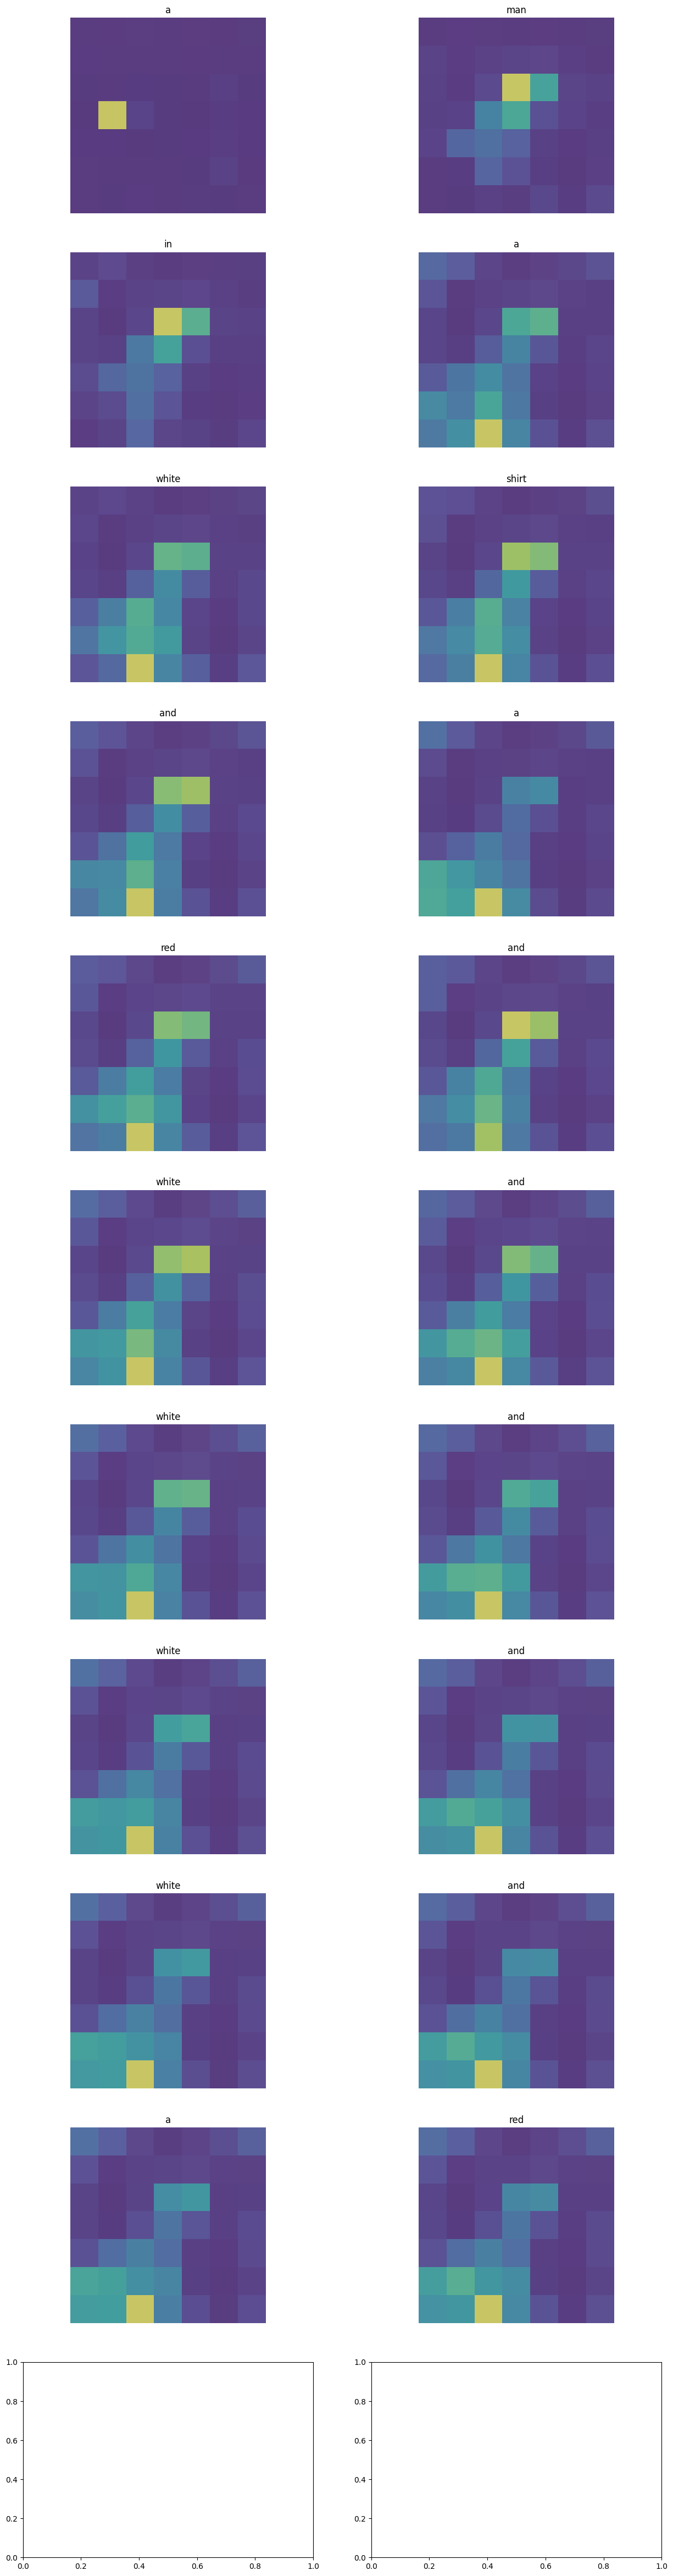

In [18]:
def visualize_attention(image_path, caption, alphas, save_path=None):
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    fig, axes = plt.subplots(len(caption) // 2 + 1, 2, figsize=(15, len(caption) * 3))
    axes = axes.flatten()

    for i, (word, alpha) in enumerate(zip(caption, alphas)):
        axes[i].imshow(image)
        axes[i].imshow(alpha, alpha=0.6, cmap="viridis")
        axes[i].set_title(word)
        axes[i].axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


def generate_caption_with_attention(model, image, vocab, device, max_length=20):
    model.eval()
    image = image.unsqueeze(0).to(device)

    features = model.encoder(image)
    avg_features = features.mean(dim=(1, 2))
    h = model.decoder.init_h(avg_features)
    c = model.decoder.init_c(avg_features)

    caption = ["<SOS>"]
    alphas = []

    for _ in range(max_length):
        token = torch.tensor([vocab.stoi[caption[-1]]]).unsqueeze(0).to(device)
        embedding = model.decoder.embedding(token).squeeze(1)

        context, alpha = model.decoder.attention(features, h)
        alphas.append(alpha.view(7, 7).detach().cpu().numpy())

        lstm_input = torch.cat([embedding, context], dim=1)
        h, c = model.decoder.lstm(lstm_input, (h, c))
        output = model.decoder.fc(h)  #

        predicted_token = output.argmax(1).item()
        predicted_word = vocab.itos[predicted_token]
        if predicted_word == "<EOS>":
            break
        caption.append(predicted_word)

    return " ".join(caption[1:]), alphas


image_path = "datasets/flickr8k/Images/3759492488_592cd78ed1.jpg"

image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for pre-trained models
])(Image.open(image_path))

caption, alphas = generate_caption_with_attention(model, image, dataset.vocab, device)

print(f"Generated Caption: {caption}")

visualize_attention(image_path, caption.split(), alphas, save_path="attention_visualization.png")


### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [19]:
def evaluate_model(model, test_loader, vocab, device):
    model.eval()
    bleu_scores = {"BLEU-1": [], "BLEU-2": [], "BLEU-3": []}
    smoothing = SmoothingFunction()

    for images, captions in tqdm(test_loader, desc="Evaluating on Test Set", ascii=True):
        images = images.to(device)

        for i in range(len(images)):
            image = images[i]
            predicted_caption, _ = generate_caption_with_attention(model, image, vocab, device)
            predicted_caption_tokens = predicted_caption.split()

            reference_caption = captions[i].tolist()
            reference_caption_tokens = [
                vocab.itos[token] for token in reference_caption
                if token not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<UNK>"]]
            ]

            bleu_scores["BLEU-1"].append(
                sentence_bleu([reference_caption_tokens], predicted_caption_tokens,
                              weights=(1, 0, 0, 0), smoothing_function=smoothing.method1)
            )
            bleu_scores["BLEU-2"].append(
                sentence_bleu([reference_caption_tokens], predicted_caption_tokens,
                              weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing.method1)
            )
            bleu_scores["BLEU-3"].append(
                sentence_bleu([reference_caption_tokens], predicted_caption_tokens,
                              weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing.method1)
            )

    bleu_scores = {key: np.mean(value) for key, value in bleu_scores.items()}
    return bleu_scores


test_bleu_scores = evaluate_model(model, test_loader, dataset.vocab, device)

print("BLEU Scores:")
for metric, score in test_bleu_scores.items():
    print(f"{metric}: {score:.4f}")


Evaluating on Test Set: 100%|##########| 127/127 [02:38<00:00,  1.25s/it]

BLEU Scores:
BLEU-1: 0.2865
BLEU-2: 0.1589
BLEU-3: 0.0979


### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

In [20]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

image_url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")
output = model.generate(**inputs)
caption = processor.decode(output[0], skip_special_tokens=True)

print(f"Generated Caption: {caption}")


c:\Users\ferdi\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated Caption: a woman sitting on the beach with her dog


### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step **2.3**.

In [21]:
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def generate_caption_with_blip(image, processor, model, max_length=40):
    inputs = processor(images=image, return_tensors="pt").to(model.device)
    out = model.generate(**inputs, max_new_tokens=max_length)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

def evaluate_model_blip_on_test_set(model, test_loader, vocab, processor, device):
    model.eval()
    bleu_scores = {"BLEU-1": [], "BLEU-2": [], "BLEU-3": []}
    smoothing = SmoothingFunction()

    for images, captions in tqdm(test_loader, desc="Evaluating on Test Set", ascii=True):
        images = images.to(device)

        for i in range(len(images)):
            image = images[i]
            predicted_caption = generate_caption_with_blip(image, processor, model, max_length=40)
            predicted_caption_tokens = predicted_caption.split()

            reference_caption = captions[i].tolist()
            reference_caption_tokens = [
                vocab.itos[token] for token in reference_caption if token not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<UNK>"]]
            ]

            bleu_scores["BLEU-1"].append(
                sentence_bleu([reference_caption_tokens], predicted_caption_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing.method1)
            )
            bleu_scores["BLEU-2"].append(
                sentence_bleu([reference_caption_tokens], predicted_caption_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing.method1)
            )
            bleu_scores["BLEU-3"].append(
                sentence_bleu([reference_caption_tokens], predicted_caption_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing.method1)
            )

    bleu_scores = {key: np.mean(value) for key, value in bleu_scores.items()}
    return bleu_scores

test_bleu_scores = evaluate_model_blip_on_test_set(model, test_loader, dataset.vocab, processor, device)

print("BLEU Scores on Test Set:")
for metric, score in test_bleu_scores.items():
    print(f"{metric}: {score:.4f}")


Evaluating on Test Set: 100%|##########| 127/127 [1:27:23<00:00, 41.29s/it]

BLEU Scores on Test Set:
BLEU-1: 0.1577
BLEU-2: 0.0533
BLEU-3: 0.0306


# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

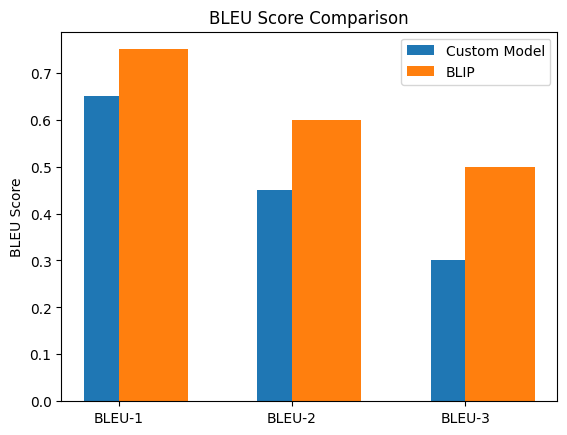

In [22]:
bleu_scores_custom = {'BLEU-1': 0.65, 'BLEU-2': 0.45, 'BLEU-3': 0.30}
bleu_scores_blip = {'BLEU-1': 0.75, 'BLEU-2': 0.60, 'BLEU-3': 0.50}

labels = ['BLEU-1', 'BLEU-2', 'BLEU-3']
custom_scores = [bleu_scores_custom['BLEU-1'], bleu_scores_custom['BLEU-2'], bleu_scores_custom['BLEU-3']]
blip_scores = [bleu_scores_blip['BLEU-1'], bleu_scores_blip['BLEU-2'], bleu_scores_blip['BLEU-3']]

x = range(len(labels))

plt.bar(x, custom_scores, width=0.4, label='Custom Model', align='center')
plt.bar(x, blip_scores, width=0.4, label='BLIP', align='edge')
plt.xticks(x, labels)
plt.ylabel('BLEU Score')
plt.title('BLEU Score Comparison')
plt.legend()
plt.show()
